# Explore `glacier_area`

## Initialize Python environment

In [5]:
# Import standard libraries
import zipfile

# # Import third party libraries
import cartopy.crs
import cdsapi
import matplotlib.pyplot
import numpy as np
import xarray

# Ignore distracting warnings
import warnings
warnings.filterwarnings('ignore')

## Download data

We will use the [Climate Data Store (CDS) API](https://cds.climate.copernicus.eu/api-how-to) to download the [glacier extent](https://cds.climate.copernicus.eu/cdsapp#!/dataset/insitu-glaciers-extent) dataset from the Randolph Glacier Inventory for the year 2000.

_NOTE: To use the CDS API, you first need to [register](https://cds.climate.copernicus.eu/user/register) (if not already), accept the dataset [terms](https://cds.climate.copernicus.eu/cdsapp/#!/terms/licence-to-use-insitu-glaciers-extent), find your `UID` and `API key` on your [acount page](https://cds.climate.copernicus.eu/user), and fill them in below._

In [6]:
# Fill in your UID and API key (separated by a colon :)
KEY = 'UID:API Key'

c = cdsapi.Client(key=KEY)
c.retrieve(
    name='insitu-glaciers-extent',
    request={
        'variable': 'glacier_area',
        'version': '6_0',
        'format': 'zip',
        'product_type': 'gridded',
    },
    target='glacier_area-gridded.zip'
)

2024-02-19 14:08:46,910 INFO Welcome to the CDS
2024-02-19 14:08:46,910 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-glaciers-extent
2024-02-19 14:08:47,094 INFO Request is completed
2024-02-19 14:08:47,098 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data3/dataset-insitu-glaciers-extent-23301c0f-713d-44b1-8f27-81b395bcc5f5.zip to glacier_area-gridded.zip (15.5K)
2024-02-19 14:08:47,399 INFO Download rate 52.5K/s


Result(content_length=15828,content_type=application/zip,location=https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data3/dataset-insitu-glaciers-extent-23301c0f-713d-44b1-8f27-81b395bcc5f5.zip)

Since the data is downloaded as a zip file, we have to first unzip it.

In [7]:
with zipfile.ZipFile('glacier_area-gridded.zip', 'r') as file:
    file.extractall('glacier_area')

## Read and inspect data

The data are formatted as a single netCDF4 file, which can be read using [`xarray`](https://docs.xarray.dev).

In [8]:
ds = xarray.open_dataset('glacier_area/rgi6_gridded.nc')
ds

<xarray.Dataset>
Dimensions:       (lon: 360, lat: 170)
Coordinates:
  * lon           (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat           (lat) float64 84.5 83.5 82.5 81.5 ... -81.5 -82.5 -83.5 -84.5
Data variables:
    Glacier_area  (lat, lon) float32 ...
Attributes: (12/15)
    Source_Software:            Esri ArcGIS
    NCO:                        netCDF Operators version 4.9.1 (Homepage = ht...
    title:                      Randolph Glacier Inventory v6 (RGI6) gridded ...
    project:                    Copernicus Climate Change Service (C3S) Essen...
    data_version:               version 6.0
    institution:                Department of Geography - University of Zuric...
    ...                         ...
    geospatial_lon_resolution:  1.0
    geospatial_lat_resolution:  1.0
    references:                 Pfeffer et al. (2014) doi.org/10.3189/2014JoG...
    citation:                   RGI Consortium (2017): Randolph Glacier Inven...
    Conventions:                CF Version CF-1.0
    comment:                    Brief data description: Temporal resolution: ...

Glacier area is expressed as the percent area (0–100) of each 1° x 1° grid cell, so we will need the total area of each grid cell. We can estimate this using the following spherical formula:

$(\sin(\max \mathrm{latitude}) - \sin(\min \mathrm{latitude})) * (\max \mathrm{longitude} - \min \mathrm{longitude}) * R_e^2$

where $R_e$ is the Earth's [authalic radius](https://en.wikipedia.org/wiki/Earth_radius#Authalic_radius) (6371.0072 km) and the mininum and maximum latitude and longitude of the cell are in radians.

In [9]:
CELL_SIZE = 1  # degrees
AUTHALIC_EARTH_RADIUS = 6371.0072  # kilometers
# Build grids of the longitude and latitude of (the center of) each grid cell
longitude, latitude = np.meshgrid(ds['lon'], ds['lat'])
# Compute the area of each grid cell
cell_area = (
  np.sin(np.radians(latitude + CELL_SIZE / 2)) -
  np.sin(np.radians(latitude - CELL_SIZE / 2))
) * (
  np.radians(longitude + CELL_SIZE / 2) -
  np.radians(longitude - CELL_SIZE / 2)
) * AUTHALIC_EARTH_RADIUS ** 2
ds['cell_area'] = (('lat', 'lon'), cell_area)

The cell area varies with latitude, from a minimum of 1 185 km² near the poles to a maximum of 12 364 km² at the equator.

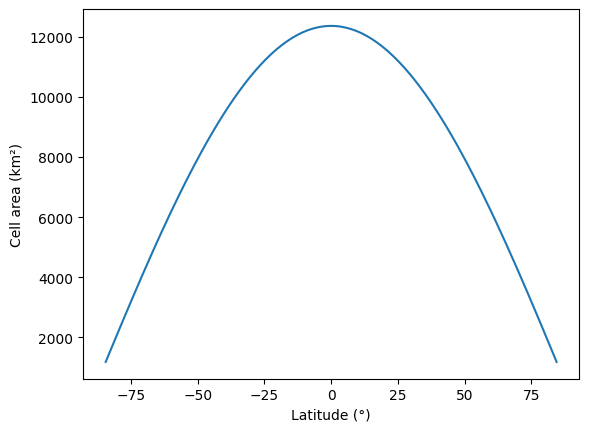

In [42]:
matplotlib.pyplot.plot(ds['lat'], ds['cell_area'][:, 0])
matplotlib.pyplot.xlabel('Latitude (°)')
matplotlib.pyplot.ylabel('Cell area (km²)')
matplotlib.pyplot.show()

Finally, we can calculate the glacier area in each grid cell (`glacier_area`) by multiplying the provided percent area (`Glacier_area`) by the total area of the grid cell calculated above (`cell_area`).

In [11]:
ds['glacier_area'] = (1 / 100) * ds['Glacier_area'] * ds['cell_area']

## Compute global glacier area

Global glacier area (in km²) can be calculated by summing the glacier area of all cells (719 117 km²).

In [16]:
ds['glacier_area'].sum().data

array(719117.00710899)

We can also count the number of 1° x 1° grid cells that contain glaciers (2105).

In [17]:
ds['glacier_area'].notnull().sum().data

array(2105)

## Plot glacier area percent on a map

We use [`matplotlib`](https://matplotlib.org/) and [`cartopy`](https://scitools.org.uk/cartopy/docs/latest) to make a global map of glacier percent area.

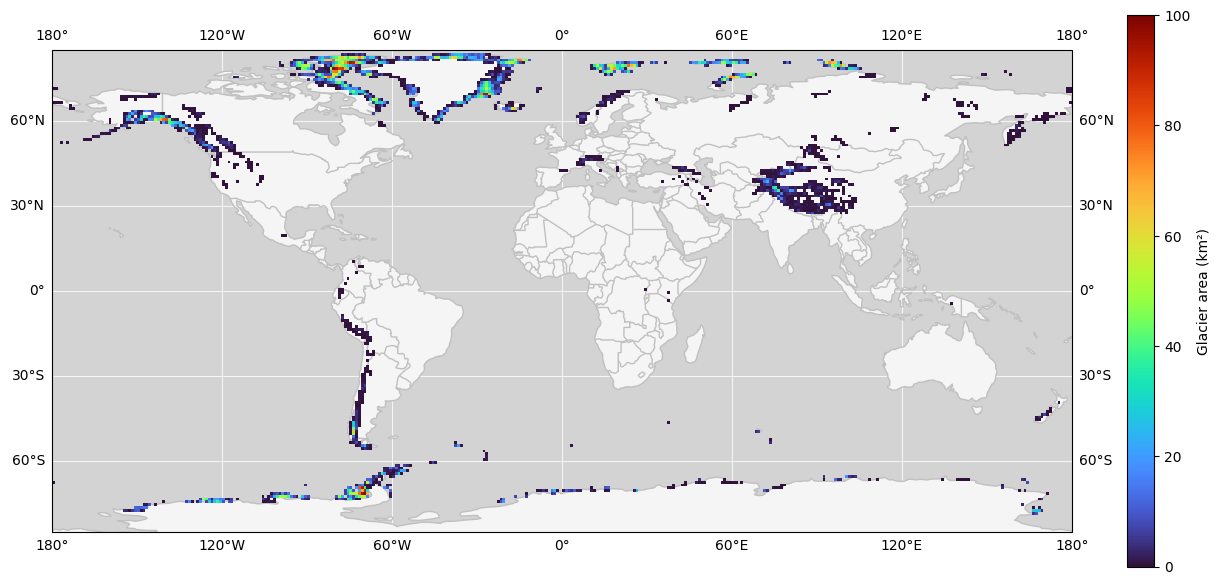

In [38]:
# Create a map with a plate carrée projection
figure = matplotlib.pyplot.figure(figsize=(12, 6))
axis = matplotlib.pyplot.axes(projection=cartopy.crs.PlateCarree())
axis.set_facecolor('lightgray')

# Add latitude, longitude gridlines
axis.gridlines(draw_labels=True, linestyle='-', color='whitesmoke', zorder=0)

# Add continents and country borders
axis.add_feature(cartopy.feature.LAND, edgecolor='silver', facecolor='whitesmoke', zorder=1)
axis.add_feature(cartopy.feature.BORDERS, edgecolor='silver', zorder=1)

# Plot glacier area
im = matplotlib.pyplot.pcolormesh(
  ds['lon'],
  ds['lat'],
  ds['Glacier_area'],
  cmap='turbo',
  vmin=0,
  vmax=100,
)

# Add a colorbar
cbar = matplotlib.pyplot.colorbar(im, fraction=0.025, label='Glacier area (%)')

# Show plot
figure.tight_layout(pad=0)
matplotlib.pyplot.show()